In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from matplotlib import rcParams

rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 15

# Define wave at initial time $t_0$

### Define spatial grid

In [3]:
x_arr = np.linspace(-50,50,1001)  # equi-distanced spatial grid

delta_x = x_arr[1] - x_arr[0]  # it holds since the spatial grid is equi-distanced

### Define wave on the spatial grid

In [4]:
wave = np.exp(-x_arr ** 2, dtype=complex)  # '**' means 'power' e.g. "3 ** 2 == 9"
k0 = 0.0  # shift (translation) in k-space
wave *= np.exp(1j * k0 * x_arr)  # shift in k-space happens by multiplying exp(ikx)

### Check the shape of generated wave

<IPython.core.display.Javascript object>


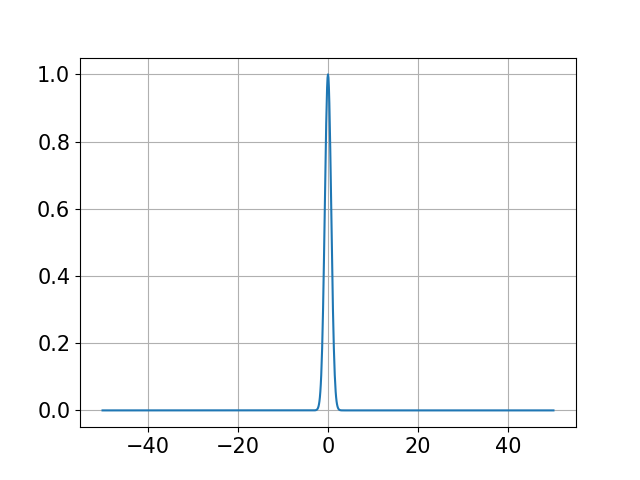

In [5]:
plt.plot(x_arr, wave.real)

# Decompose the initial wave into plane waves

## Numerical consideration: Nyquist Criteria
$\Delta{x}$ should be small enough to express plane wave with high wave number $k$.
If the wave number $k$ is too big (thus the corresponding wavelength is too small), the spatial oscillation cannot be expressed by given $\Delta{x}$

\begin{equation}
2\Delta{x} \le \lambda_{min} = \frac{2\pi}{k_{max}}
\end{equation}

In [6]:
x_min, x_max = x_arr[0], x_arr[-1]
box_size = x_max - x_min

delta_k = 2 * np.pi / box_size

In [7]:
k_max_Nyquist = np.pi / delta_x
N_k = int(k_max_Nyquist // delta_k) * 2 + 1
k_max = (k_max_Nyquist // delta_k) * delta_k

In [8]:
delta_x

0.10000000000000142

In [9]:
np.pi / k_max

0.1002004008016032

In [10]:
assert k_max != 0
assert delta_x < np.pi / k_max

In [11]:
k_arr = np.linspace(-k_max, k_max, N_k)

In [12]:
## Define a container for components of each plane wave
k_components = np.empty_like(k_arr, dtype=np.complex)

## Calculate components of each plane wave
for k_index in range(k_arr.size):
    # construct a plane wave array
    wave_k = np.exp(1.0j * k_arr[k_index] * x_arr)
    
    # Project the plane wave to the initial wave
    product = wave_k.conjugate() * wave
    inner_product = (product[:-1] + product[1:]).sum() * delta_x - 0.5 * (product[0] + product[-1])
    
    # Store the calculated component into the container array
    k_components[k_index] = inner_product

### Plot k-spectrum

<IPython.core.display.Javascript object>


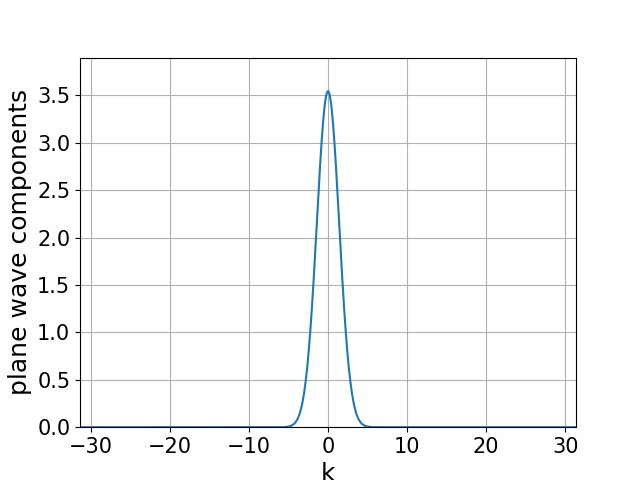

Text(0,0.5,'plane wave components')

In [13]:
fig = plt.figure()
ax = fig.gca()

k_spectrum_abs = np.abs(k_components)
ax.plot(k_arr, k_spectrum_abs)
ax.set_xlim(-k_max, k_max)
ax.set_ylim(0, k_spectrum_abs.max() * 1.1)
ax.set_xlabel('k')
ax.set_ylabel('plane wave components')

# Define dispersion relation $\omega(k)$

In [14]:
# def omega(k): return 1.0 * k  # linear dispersion
def omega(k): return 1.0 * np.abs(k)  # absolute linear dispersion
#def omega(k): return 1.0 * k + 2.0
#def omega(k): return 1.0 * np.abs(k*k)  # quad
#def omega(k): return 3.0 * np.abs(k*k*k)  # trigometric

# Test Reconstruction
### : from k-spectrum to x-spectrum (spatial spectrum)

In [15]:
K, X = np.meshgrid(k_arr, x_arr, indexing='ij')

In [16]:
t = 4.0

basis = np.exp(1j * (K * X - omega(K) * t))

wave_at_t = np.einsum(k_components, [0], basis, [0,1])

<IPython.core.display.Javascript object>


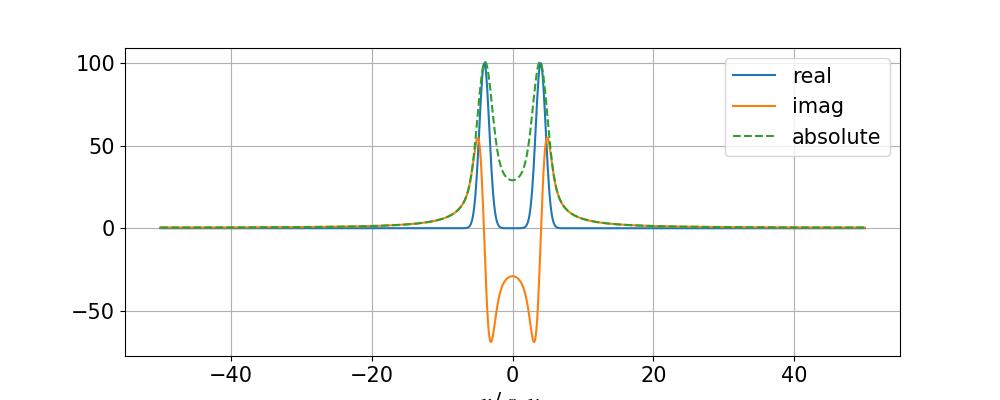

Text(0.5,0,'$x\\,/\\,a.u.$')

In [17]:
fig = plt.figure(figsize=(10,4))
ax = fig.gca()

ax.plot(x_arr, wave_at_t.real, label='real')
ax.plot(x_arr, wave_at_t.imag, label='imag')
ax.plot(x_arr, np.abs(wave_at_t), '--', label='absolute')

ax.legend()

ax.set_xlabel(r'$x\,/\,a.u.$')

In [18]:
#fig.savefig('wave.png')

# Visualize Decomposition

### Define time array

In [19]:
t_array = np.linspace(0,100,1000)

### Determine k values to be plotted

In [20]:
assert (k_arr.size % 2) == 1  # The number of k array should be odd
k_zero_indice = k_arr.size // 2
assert k_arr[k_zero_indice] == 0

In [21]:
k_num = 4
k_index_interval = 10
k_indices = np.arange(k_zero_indice - k_num * k_index_interval, 
                      k_zero_indice + k_num * (k_index_interval+1), 
                      k_index_interval)

k_values = k_arr[k_indices]

### Configure appearence for plotting

In [22]:
## Calculate maximum amplitude for each wave
y_height = 0.5 * np.diff(k_values).min()
padding_factor = 0.9
y_height *= padding_factor

In [23]:
ylim = (k_values[0]-y_height*1.2, k_values[-1]+y_height*1.2)
xlim = (x_arr[0],x_arr[-1])

In [24]:
## Calculate weight of each plane wave's amplidude
## .. according to its k-component
weights = np.abs(k_components[k_indices])
weights /= weights.max()

### Define functions which return data for given time $t$

In [25]:
Omega = omega(K)

non_zero_mask = k_values != 0
non_zero_k_values = k_values[non_zero_mask]
v_phases = omega(non_zero_k_values) / non_zero_k_values

def get_y_total(t):
    basis = np.exp(1j * (K * X - Omega * t))
    wave_at_t = np.einsum(k_components, [0], basis, [0,1])
    original_height = np.abs(wave_at_t).max()
    y_total = y_height / original_height * wave_at_t
    return y_total

def get_centers(t): return v_phases * t

### Define functions for animation

<IPython.core.display.Javascript object>


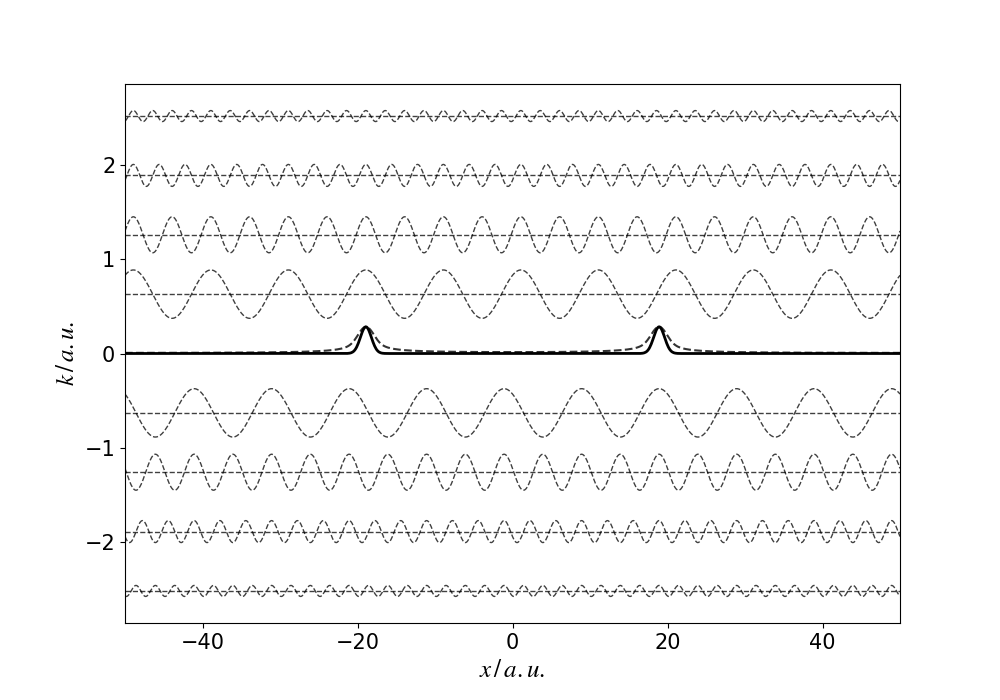

In [32]:
fig, ax = plt.subplots(figsize=(10,7))

line_total, = ax.plot([],[], color='black', linewidth=2)
line_total_envol, = ax.plot([],[], color=(0,0,0,0.8), linewidth=1.5, linestyle='--')
line_centers, = ax.plot([],[], color=(0.4,0,0,0.5), linewidth=1.0, linestyle='', marker='.')

lines_plane_waves, lines_centers, lines_horizons = [], [], []
for k_idx in range(k_values.size):
    k_value = k_values[k_idx]
    if k_value == 0: continue
    lines_plane_waves.append(ax.plot([],[], color=(0,0,0,0.75), linewidth=1.0, linestyle='--')[0])
    lines_centers.append(ax.plot([],[], marker='o', color=(0.4,0,0,1), markersize=3.0)[0])
    lines_horizons.append(ax.plot([],[], linewidth=1.0, color=(0,0,0,0.75), linestyle='--')[0])

## Combine lines
lines = [line_total, line_centers, line_total_envol]
for line_list in [lines_plane_waves, lines_centers, lines_horizons]:
    lines += line_list

    
def init():
    ax.set_ylabel(r'$k\,/\,a.u.$')
    ax.set_xlabel(r'$x\,/\,a.u.$')
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.grid(False)
    return lines

def update(t):
    y_total = get_y_total(t)
    line_total.set_data(x_arr, y_total.real)
    line_total_envol.set_data(x_arr, np.abs(y_total))
    line_centers.set_data(get_centers(t), non_zero_k_values)
    idx = 0
    for k_idx in range(k_values.size):
        k_value = k_values[k_idx]
        if k_value == 0: continue
        wave_k = np.exp(1j * (k_value * x_arr - omega(k_value) * t))
        v_phase = omega(k_value) / k_value
        center = v_phase * t
        y = wave_k.real
        y_original_height = y.max()
        y *= weights[k_idx] * y_height / y_original_height
        
        lines_plane_waves[idx].set_data(x_arr, y + k_value)
        lines_centers[idx].set_data(center, k_value)
        lines_horizons[idx].set_data([x_arr[0],x_arr[-1]], [k_value, k_value])
        
        idx += 1
        
    return lines

from matplotlib.animation import FuncAnimation
ani = FuncAnimation(fig, update, frames=t_array[::10], init_func=init, blit=True)

### Redering animation

In [28]:
from matplotlib.animation import PillowWriter

video_writer = PillowWriter(fps=10)

In [29]:
dispersion_rel = 'abs-linear'

In [30]:
ani_file_name = 'periodic-k0-{0}-delta_k-{1:.3}-delta_x-{2:.3}-dispersion-{3}.gif'.format(k0, delta_k, delta_x, dispersion_rel)
print(ani_file_name)

periodic-k0-0.0-delta_k-0.0628-delta_x-0.1-dispersion-abs-linear.gif


#### Save animation

In [33]:
ani.save(ani_file_name, writer=video_writer)